<a href="https://colab.research.google.com/github/parth-u/Time-Stock-Horizon-Stock-Prediction-Tool/blob/main/Stockmarketprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading the data

First, we'll download the data from Yahoo Finance.  To do this, we'll use the `yfinance` python package.  We can install this by typing `pip install yfinance` in the command line (or typing `!pip install yfinance` in Jupyter notebook).

We'll use data for a single stock (Microsoft) from when it started trading to the present.

In [ ]:
import yfinance as yf

msft = yf.Ticker("AMZN")
msft_hist = msft.history(period="max")

We've now downloaded the data!  In the real world, we want to save the data to disk, so we can access it again if we need it without calling the API over and over.  We can do this by checking if we've saved the data before.  If we have, we just load the data.  Otherwise, we download the data.

We'll need to install `pandas` to do this.

In [ ]:
import os
import pandas as pd

DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        msft_hist = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("AMZN")
    msft_hist = msft.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    msft_hist.to_json(DATA_PATH)

In [ ]:
msft_hist.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2024-04-29 04:00:00,405.250000,406.320007,399.190002,402.250000,19582100,0.0,0.0
2024-04-30 04:00:00,401.489990,402.160004,389.170013,389.329987,28781400,0.0,0.0
2024-05-01 04:00:00,392.609985,401.720001,390.309998,394.940002,23562500,0.0,0.0
2024-05-02 04:00:00,397.660004,399.929993,394.649994,397.839996,17709400,0.0,0.0
2024-05-03 04:00:00,402.000000,407.149994,401.859985,406.660004,17446724,0.0,0.0


<Axes: >

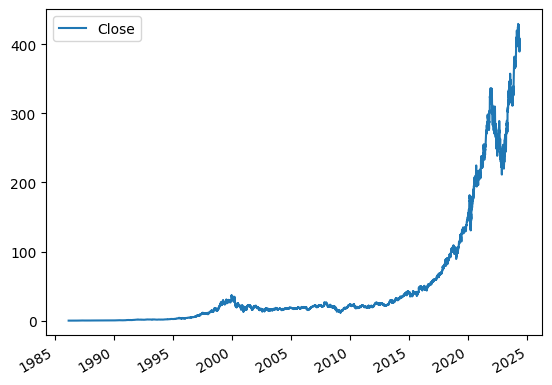

In [ ]:
# Visualize microsoft stock prices
msft_hist.plot.line(y="Close", use_index=True)

In [ ]:
# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [ ]:
data.head(5)

,Actual_Close,Target
1986-03-13 05:00:00,0.060163,NaN
1986-03-14 05:00:00,0.062311,1.0
1986-03-17 05:00:00,0.063386,1.0
1986-03-18 05:00:00,0.061774,0.0
1986-03-19 05:00:00,0.060700,0.0


### Shifting data "forward"

Next, we'll use the DataFrame [shift](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html?highlight=shift#pandas.DataFrame.shift) method to move all rows "forward" one trading day.

As you can see, the prices for `1986-03-13` are now associated with `1986-03-14`, and every other price is shifted up one row.  This is to ensure that we're predicting future prices using past data.

If we didn't do this, we'd be using data from `03-14` to predict prices on `03-14`.  Instead, we need to use data from `03-13` to predict prices on `03-14`.  If we don't do this, our model will look amazing when we're testing it, but won't work at all in the real world.  In the real world, we don't actually know the price tomorrow, so we can't use it to make our predictions.

In [ ]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [ ]:
msft_prev.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14 05:00:00,0.054792,0.062849,0.054792,0.060163,1.031789e+09,0.0,0.0
1986-03-17 05:00:00,0.060163,0.063386,0.060163,0.062311,3.081600e+08,0.0,0.0
1986-03-18 05:00:00,0.062311,0.063923,0.062311,0.063386,1.331712e+08,0.0,0.0
1986-03-19 05:00:00,0.063386,0.063923,0.061237,0.061774,6.776640e+07,0.0,0.0
1986-03-20 05:00:00,0.061774,0.062311,0.060163,0.060700,4.789440e+07,0.0,0.0
1986-03-21 05:00:00,0.060700,0.060700,0.058551,0.059089,5.843520e+07,0.0,0.0
1986-03-24 05:00:00,0.059089,0.060163,0.056403,0.057477,5.999040e+07,0.0,0.0
1986-03-25 05:00:00,0.057477,0.057477,0.055329,0.055866,6.528960e+07,0.0,0.0
1986-03-26 05:00:00,0.055866,0.056940,0.055329,0.056940,3.208320e+07,0.0,0.0


### Combining our data

Next, we need to combine our `Target` with the columns we want to use to predict the target.  We'll use this with the [join](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html?highlight=join#pandas.DataFrame.join) method on DataFrames.

After we join our data, we see that we'll be predicting the target using data from the previous day.  The columns we'll use to predict our target are `["Close", "Volume", "Open", "High", "Low"]`.

It's good to be explicit with `predictors` to avoid accidentally using your target to predict itself.  This will make your model look really good in training, but won't work at all in the real world.

In [ ]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

In [ ]:
data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
1986-03-14 05:00:00,0.062311,1.0,0.060163,1.031789e+09,0.054792,0.062849,0.054792
1986-03-17 05:00:00,0.063386,1.0,0.062311,3.081600e+08,0.060163,0.063386,0.060163
1986-03-18 05:00:00,0.061774,0.0,0.063386,1.331712e+08,0.062311,0.063923,0.062311
1986-03-19 05:00:00,0.060700,0.0,0.061774,6.776640e+07,0.063386,0.063923,0.061237
1986-03-20 05:00:00,0.059089,0.0,0.060700,4.789440e+07,0.061774,0.062311,0.060163


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

### Training the model

Once we've setup the model, we can train it on the last `100` rows of the dataset.  We're using all of the data except the last `100` rows to predict the last `100` rows.  When you're working with time series data, it's important to never use future data to predict the past.

The [fit](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.fit) method will train the model using our predictors to predict the `Target`.

In [ ]:
# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

### Measuring error

Next, we'll need to check how accurate the model was.  Earlier, we mentioned using `precision` to measure error.  We can do this by using the `precision_score` function from scikit-learn.

Precision will tell us on what % of days that the algorithm said the price would go up it actually went up.  Because we want to minimize risk, we want to have a high precision.  This means that when we buy stock, we have high confidence that we'll make money.

Below, we do the following to calculate precision:

* Import the scikit-learn `precision_score` function
* Generate predictions from our model using the [predict](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict) function.  This will give us a `0` or a `1` for each row.
* The `predict` method returns a numpy array.  To make it easier to work with, we'll turn it into a pandas Series.
* Finally, we execute the `precision_score` function, passing in the predictions and the target.

As you can see below, our precision is only `.51`, which is not great.  That means that when the model predicted that prices would go up, they only went up `51%` of the time.

In [ ]:
from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5111111111111111

<Axes: >

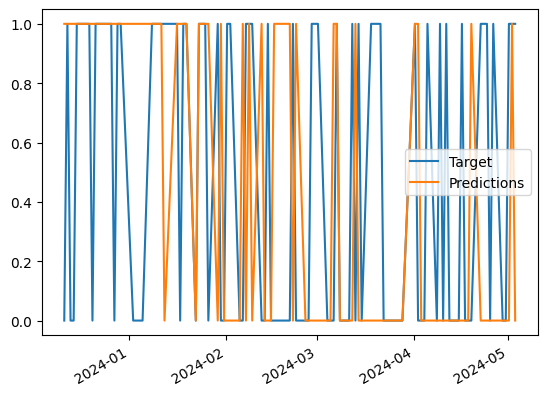

In [ ]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()